In [24]:
import pandas as pd
import spacy
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

# Cargar los datos
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

# Cargar modelo spaCy
nlp = spacy.load("en_core_web_sm")

# Funciones de preprocesamiento
def clean_text(text):
    text = re.sub(r'\W+', ' ', text)  # Eliminar caracteres no alfabéticos
    text = re.sub(r'\d+', '', text)   # Eliminar números
    return text

def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

def filter_length(text, min_len=3, max_len=20):
    return " ".join([word for word in text.split() if min_len <= len(word) <= max_len])

# Combinar y limpiar datos
df_train['text'] = (df_train['title'] + " " + df_train['description']).apply(clean_text).apply(lemmatize_text).apply(filter_length)
df_test['text'] = (df_test['title'] + " " + df_test['description']).apply(clean_text).apply(lemmatize_text).apply(filter_length)

X = df_train['text']
y = df_train['storypoint']

# División en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline de modelo
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english')),
    ('classifier', MultinomialNB())
])

# Búsqueda de hiperparámetros
# param_grid = {
#     'vectorizer__max_features': [1000, 2000, 3000],
#     'vectorizer__ngram_range': [(1, 1), (1, 2)],
#     'vectorizer__min_df': [2, 5, 10],
#     'classifier__alpha': [1.0, 2.0, 3.0, 4.0]
# }

# # MEJOR ANDUVO
# param_grid = {
#     'vectorizer__max_features': [2000, 5000, 10000],  # Limitar el tamaño del vocabulario
#     'vectorizer__ngram_range': [(1, 1), (1, 2)],      # Incluir unigramas y bigramas
#     'vectorizer__min_df': [5, 10, 20],                # Filtrar palabras raras
#     'classifier__alpha': [1.0, 2.0, 3.0, 5.0]         # Regularización más fuerte
# }

param_grid = {
    'vectorizer__max_features': [5000, 10000, 20000, 30000, 40000],  # Limitar el tamaño del vocabulario
    'vectorizer__ngram_range': [(1, 1), (1, 2)],      # Incluir unigramas y bigramas
    'vectorizer__min_df': [3, 5, 10, 15, 20],                # Filtrar palabras raras
    'classifier__alpha': [0.5, 1.0, 2.0, 3.0, 5.0]         # Regularización más fuerte
}

scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=scorer, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Evaluar el mejor modelo
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)
rmse = mean_squared_error(y_val, y_val_pred, squared=False)
print(f"RMSE en validación: {rmse}")

# Generar submission
test_predictions = best_model.predict(df_test['text'])
submission = pd.DataFrame({'id': df_test['id'], 'storypoint': test_predictions})
submission.to_csv('submit.csv', index=False)
print("Archivo 'submit.csv' generado correctamente")


Fitting 5 folds for each of 250 candidates, totalling 1250 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE en validación: 2.663275797712949
Archivo 'submit.csv' generado correctamente


In [8]:
# # Mostrar los mejores hiperparámetros
# best_params = grid_search.best_params_
# print(f"Mejores hiperparámetros: {best_params}")

Mejores hiperparámetros: {'classifier__alpha': 4.0, 'vectorizer__max_features': 3000, 'vectorizer__min_df': 5, 'vectorizer__ngram_range': (1, 1)}


In [18]:
# # Mostrar los mejores hiperparámetros
# best_params = grid_search.best_params_
# print(f"Mejores hiperparámetros: {best_params}")

Mejores hiperparámetros: {'classifier__alpha': 5.0, 'vectorizer__max_features': 10000, 'vectorizer__min_df': 5, 'vectorizer__ngram_range': (1, 2)}


In [25]:
# Mostrar los mejores hiperparámetros
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

Mejores hiperparámetros: {'classifier__alpha': 5.0, 'vectorizer__max_features': 20000, 'vectorizer__min_df': 3, 'vectorizer__ngram_range': (1, 2)}


In [26]:
import joblib
from joblib import load

joblib.dump(best_model, 'best_model_NB_Tfidf_with_title.pkl')

['best_model_NB_Tfidf_with_title.pkl']

# Investigacion

## Inspección y Ajuste de max_features

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

# Inspección del vocabulario
vectorizer = CountVectorizer()
X_counts = vectorizer.fit_transform(df_train['text'])
vocab_size = len(vectorizer.vocabulary_)
print(f"Tamaño del vocabulario después del preprocesamiento: {vocab_size}")

Tamaño del vocabulario después del preprocesamiento: 19016


## Inspección y Ajuste de ngram_range

In [10]:
# Longitud promedio de los textos
text_lengths = df_train['text'].apply(lambda x: len(x.split()))
avg_length = text_lengths.mean()
print(f"Longitud promedio de los textos: {avg_length}")

Longitud promedio de los textos: 74.04708860759494


## Inspección y Ajuste de min_df

In [11]:
import numpy as np

# Distribución de frecuencias de palabras
word_counts = np.asarray(X_counts.sum(axis=0)).flatten()
freq_distribution = np.bincount(word_counts)
print(f"Frecuencia de palabras: {freq_distribution}")

Frecuencia de palabras: [   0 7426 3100 ...    0    0    1]


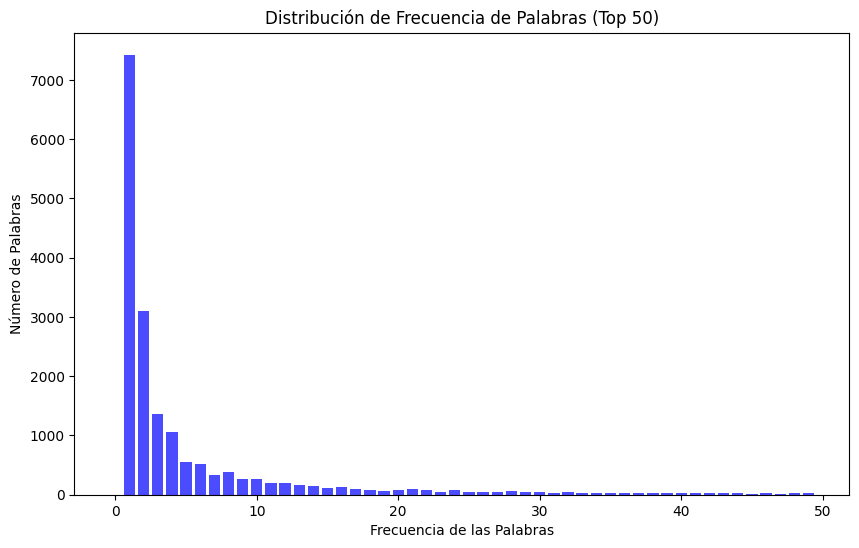

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Calcular la frecuencia de palabras
word_counts = np.asarray(X_counts.sum(axis=0)).flatten()
freq_distribution = np.bincount(word_counts)

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.bar(range(len(freq_distribution[:50])), freq_distribution[:50], color='blue', alpha=0.7)
plt.title('Distribución de Frecuencia de Palabras (Top 50)')
plt.xlabel('Frecuencia de las Palabras')
plt.ylabel('Número de Palabras')
plt.show()

## Inspección y Ajuste de alpha

In [13]:
# Distribución de las etiquetas
label_distribution = y_train.value_counts()
print(label_distribution)

storypoint
3     1465
5     1378
1     1298
2     1005
8      829
4      134
13     128
20      24
10      21
6       14
16       7
40       5
12       4
7        2
15       2
21       2
34       1
32       1
Name: count, dtype: int64
